# Description

In this work, the convolutional neural network LeNet will be improved (Activation, Batch Normalization, Max Pooling, kernel size, etc).

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision.datasets

import warnings
warnings.filterwarnings("ignore")

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

# Tasks

Task 1. Сompare improvements of the LeNet convolutional neural network for recognizing handwritten numbers on images (Activation, Batch Normalization, Max Pooling, kernel size, etc).

__Data preparation__

In [3]:
mnist_train = torchvision.datasets.MNIST('./', download=True, train=True)
mnist_test = torchvision.datasets.MNIST('./', download=True, train=False)
X_train = mnist_train.train_data
y_train = mnist_train.train_labels
X_test = mnist_test.test_data
y_test = mnist_test.test_labels

tensor(5)


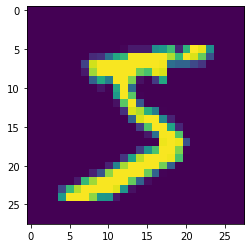

In [4]:
# display an example of the data
plt.imshow(X_train[0, :, :])
print(y_train[0])

In [5]:
# reshape the data
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [6]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

torch.Size([60000, 1, 28, 28]) torch.Size([10000, 1, 28, 28])
torch.Size([60000]) torch.Size([10000])


__Model__

In [7]:
class LeNet5(torch.nn.Module):
    
    def __init__(self, activation='tanh', pooling='avg', conv_size=5, use_batch_norm=False):
        super(LeNet5, self).__init__()
        
        self.conv_size = conv_size
        self.use_batch_norm = use_batch_norm
        
        if activation == 'tanh':
            activation_function = torch.nn.Tanh()
        elif activation == 'relu':
            activation_function = torch.nn.ReLU()
        else:
            raise NotImplementedError
            
        if pooling == 'avg':
            pooling_layer = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        elif pooling == 'max':
            pooling_layer = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        else:
            raise NotImplementedError
            
        if conv_size == 5:
            self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
        elif conv_size == 3:
            self.conv1_1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, padding=1)
            self.conv1_2 = torch.nn.Conv2d(in_channels=6, out_channels=6, kernel_size=3, padding=1)
        else:
            raise NotImplementedError
            
        self.act1 = activation_function
        self.bn1 = torch.nn.BatchNorm2d(num_features=6)
        self.pool1 = pooling_layer
        
        if conv_size == 5:
            self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0)
        elif conv_size == 3:
            self.conv2_1 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, padding=0)
            self.conv2_2 = torch.nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=0)
        else:
            raise NotImplementedError
            
        self.act2 = activation_function
        self.bn2 = torch.nn.BatchNorm2d(num_features=16)
        self.pool2 = pooling_layer
        
        self.fc1 = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3 = activation_function

        self.fc2 = torch.nn.Linear(120, 84)
        self.act4 = activation_function
        
        self.fc3 = torch.nn.Linear(84, 10)
        
    def forward(self, x):
        if self.conv_size == 5:
            x = self.conv1(x)
        elif self.conv_size == 3:
            x = self.conv1_2(self.conv1_1(x))
        
        x = self.act1(x)
        
        if self.use_batch_norm:
            x = self.bn1(x)
        
        x = self.pool1(x)
        
        if self.conv_size == 5:
            x = self.conv2(x)
        elif self.conv_size == 3:
            x = self.conv2_2(self.conv2_1(x))
        
        x = self.act2(x)
        
        if self.use_batch_norm:
            x = self.bn2(x)
        
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        
        x = self.fc1(x)
        x = self.act3(x)

        x = self.fc2(x)
        x = self.act4(x)

        x = self.fc3(x)
        
        return x

In [8]:
def train(net, X_train, y_train, X_test, y_test):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3)
    batch_size = 100

    test_accuracy_history = []
    test_loss_history = []
        
    X_test = X_test.to(device)
    y_test = y_test.to(device)
        
    for epoch in range(30):
        order = np.random.permutation(len(X_train))
            
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            net.train()

            batch_indexes = order[start_index:start_index+batch_size]
            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            preds = net.forward(X_batch)
            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()

        with torch.no_grad():
            net.eval()
                
            test_preds = net.forward(X_test)
            test_loss_history.append(loss(test_preds, y_test).data.cpu())
            accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
            test_accuracy_history.append(accuracy)
                
    return test_accuracy_history, test_loss_history

Text(0.5, 1.0, 'Validation Accuracy')

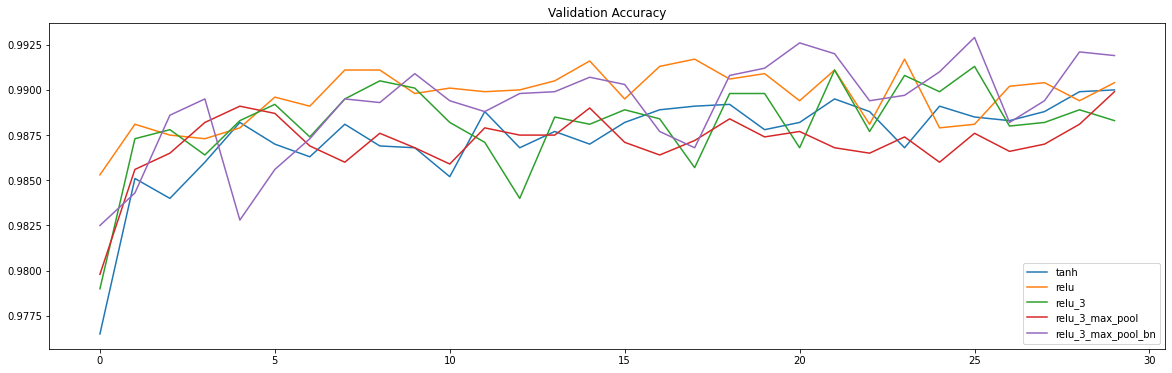

In [9]:
accuracies = {}
losses = {}

accuracies['tanh'], losses['tanh'] = train(LeNet5(activation='tanh', conv_size=5), X_train, y_train, X_test, y_test)
accuracies['relu'], losses['relu'] = train(LeNet5(activation='relu', conv_size=5), X_train, y_train, X_test, y_test)
accuracies['relu_3'], losses['relu_3'] = train(LeNet5(activation='relu', conv_size=3), X_train, y_train, X_test, y_test)
accuracies['relu_3_max_pool'], losses['relu_3_max_pool'] = \
train(LeNet5(activation='relu', conv_size=3, pooling='max'), X_train, y_train, X_test, y_test)
accuracies['relu_3_max_pool_bn'], losses['relu_3_max_pool_bn'] = \
train(LeNet5(activation='relu', conv_size=3, pooling='max', use_batch_norm=True), X_train, y_train, X_test, y_test)

fig = plt.figure(figsize=(20, 6))
for experiment_id in accuracies.keys():
    plt.plot(accuracies[experiment_id], label=experiment_id)

plt.legend()
plt.title('Validation Accuracy')

Task 2. Improve the LeNet convolutional neural network for solving the classification problem (CIFAR10 dataset).

__Data preparation__

In [10]:
cifar_train = torchvision.datasets.CIFAR10('./', download=True, train=True);
cifar_test = torchvision.datasets.CIFAR10('./', download=True, train=False);
X_train = torch.Tensor(cifar_train.data)
y_train = torch.LongTensor(cifar_train.targets)
X_test = torch.Tensor(cifar_test.data)
y_test = torch.LongTensor(cifar_test.targets)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
X_train /= 255
X_test /= 255

In [12]:
cifar_train.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

'truck'

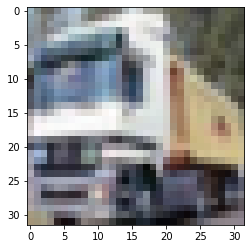

In [13]:
# display an example of the data
plt.imshow(X_train[1, :, :, :])
cifar_train.classes[y_train[1]]

In [14]:
X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)

In [15]:
# datasets shapes
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

torch.Size([50000, 3, 32, 32]) torch.Size([10000, 3, 32, 32])
torch.Size([50000]) torch.Size([10000])


__Model__

In [16]:
class LeNet5_CIFAR10(torch.nn.Module):
    
    def __init__(self):
        super(LeNet5_CIFAR10, self).__init__()
        
        self.bn0 = torch.nn.BatchNorm2d(num_features=3)

        self.conv1_1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv1_2 = torch.nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.ac1 = torch.nn.ReLU()
        self.bn1 = torch.nn.BatchNorm2d(num_features=16)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.do1 = torch.nn.Dropout2d(p=0.4)
        
        self.conv2_1 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv2_2 = torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.ac2 = torch.nn.ReLU()
        self.bn2 = torch.nn.BatchNorm2d(num_features=32)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.do2 = torch.nn.Dropout2d(p=0.4)

        self.conv3_1 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3_2 = torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.ac3 = torch.nn.ReLU()
        self.bn3 = torch.nn.BatchNorm2d(num_features=64)
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.do3 = torch.nn.Dropout2d(p=0.4)
        
        self.fc1 = torch.nn.Linear(4 * 4 * 64, 256)
        self.ac4 = torch.nn.Tanh()
        self.bn4 = torch.nn.BatchNorm1d(num_features=256)

        self.fc2 = torch.nn.Linear(256, 64)
        self.ac5 = torch.nn.Tanh()
        self.bn5 = torch.nn.BatchNorm1d(num_features=64)
        
        self.fc3 = torch.nn.Linear(64, 10)
        
    def forward(self, x):
        x = self.bn0(x)
        
        x = self.conv1_1(x)
        x = self.conv1_2(x)
        x = self.ac1(x)
        x = self.bn1(x)
        x = self.pool1(x)

        x = self.do1(x)

        x = self.conv2_1(x)
        x = self.conv2_2(x)
        x = self.ac2(x)
        x = self.bn2(x)
        x = self.pool2(x)

        x = self.do2(x)

        x = self.conv3_1(x)
        x = self.conv3_2(x)
        x = self.ac3(x)
        x = self.bn3(x)
        x = self.pool3(x)

        x = self.do3(x)

        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.ac4(x)
        x = self.bn4(x)

        x = self.fc2(x)
        x = self.ac5(x)
        x = self.bn5(x)

        x = self.fc3(x)
 
        return x

In [17]:
lenet5_cifar = LeNet5_CIFAR10()

__Device__

In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [19]:
X_test = X_test.to(device)
y_test = y_test.to(device)
lenet5_cifar = lenet5_cifar.to(device)

__Loss and optimizer__

In [20]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet5_cifar.parameters(), lr=1e-4, weight_decay=1e-5)

__Model training__

In [21]:
batch_size = 100
test_accuracy_history = []
test_loss_history = []

for epoch in range(100):
    order = np.random.permutation(len(X_train))

    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        lenet5_cifar.train()

        batch_indexes = order[start_index:start_index+batch_size]
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)

        preds = lenet5_cifar.forward(X_batch)
        loss_value = loss(preds, y_batch)
        loss_value.backward()

        optimizer.step()

    with torch.no_grad():
        lenet5_cifar.eval()

        test_preds = lenet5_cifar.forward(X_test)
        test_loss_history.append(loss(test_preds, y_test).data.cpu())

        accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
        test_accuracy_history.append(accuracy)

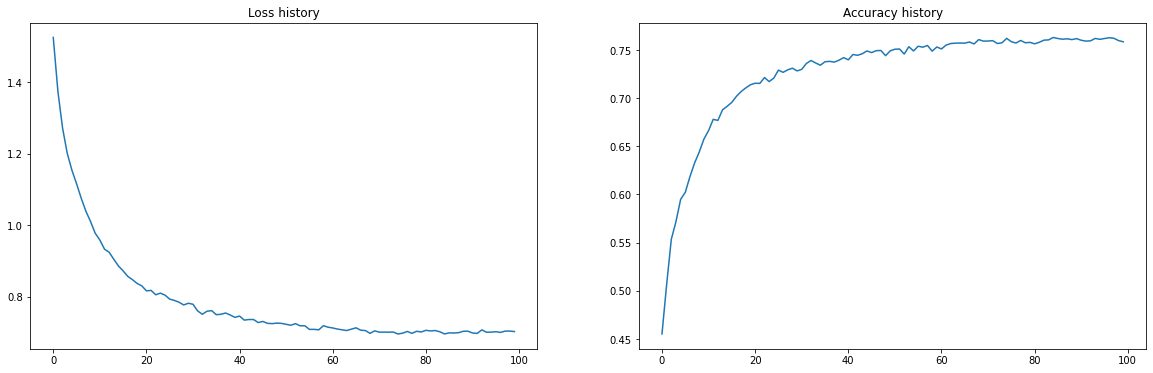

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

ax[0].plot(test_loss_history)
ax[0].title.set_text('Loss history')

ax[1].plot(test_accuracy_history)
ax[1].title.set_text('Accuracy history')